Aper√ßu du dataset:
   Age Situation maritale  Nb enfants  Nb pers √† charge  Profession du mari  \
0   60        c√©libataire           0                 1                   1   
1   46             mari√©e           1                 1         agriculteur   
2   60             mari√©e           4                 1  infirmier retrait√©   
3   48             mari√©e           5                 0          m√©canicien   
4   43             mari√©e           3                 0        a l'√©tranger   

   Domicile Niveau socio-√©conomique Tabagisme Fum√©es de Tabouna  \
0  monastir                monastir       non               oui   
1  monastir                     bon       non               oui   
2  monastir                     bon       non               oui   
3  monastir                   moyen       non               oui   
4  monastir                     bon       non               oui   

  Ant√©c√©dents familiaux  ...  TAS TAD   GAD  Examen des membres sup√©rieurs  \
0         

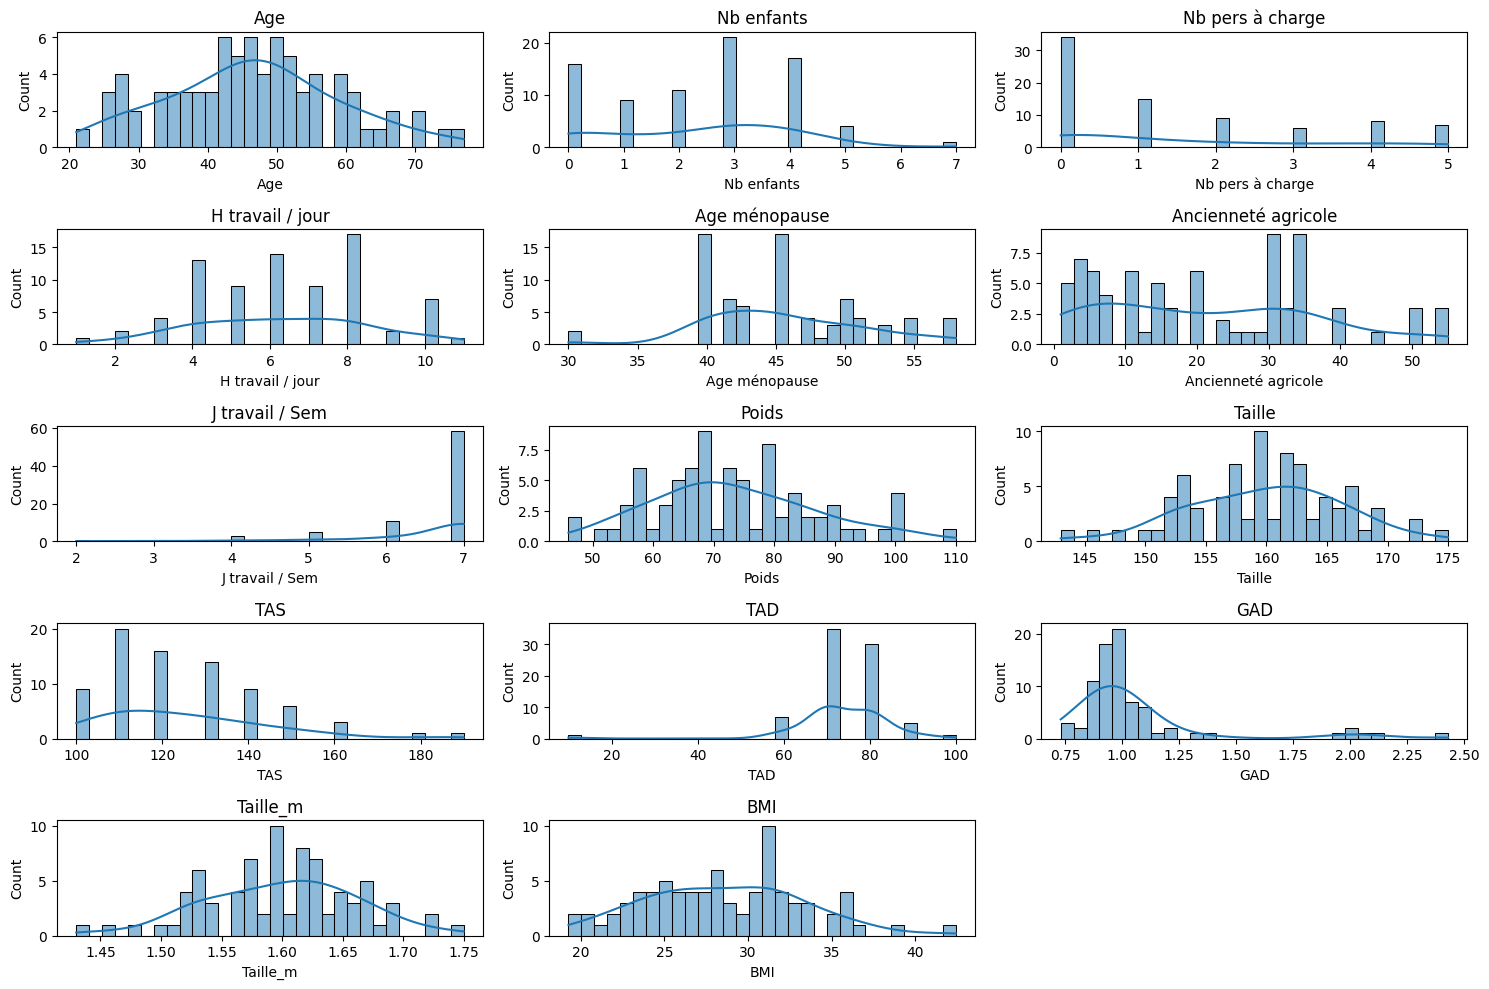

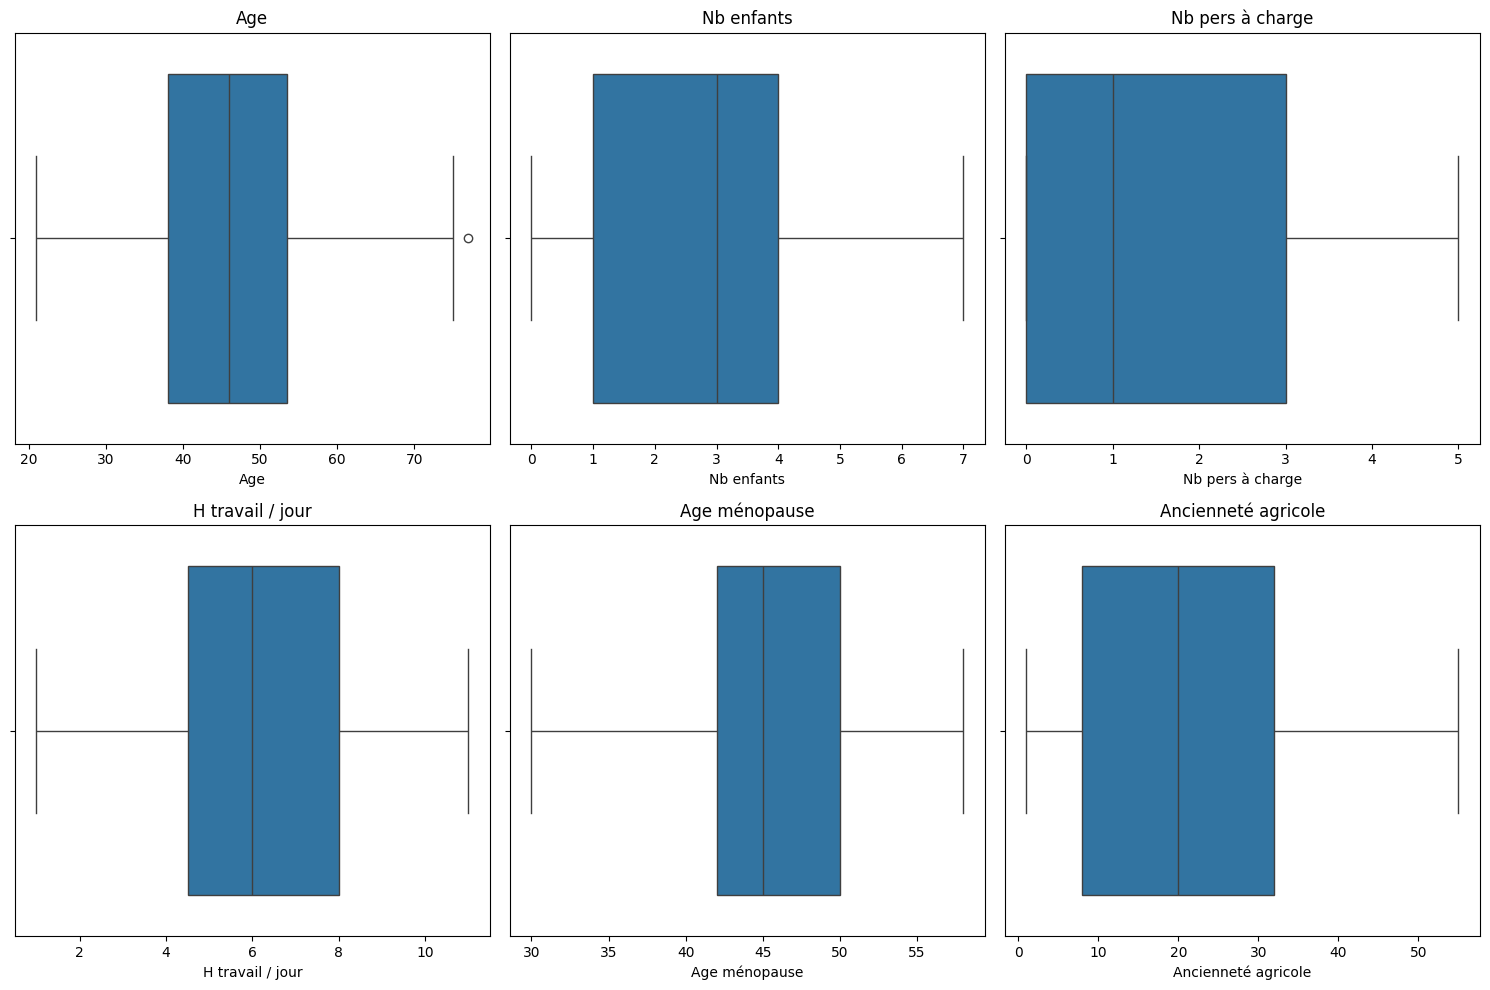

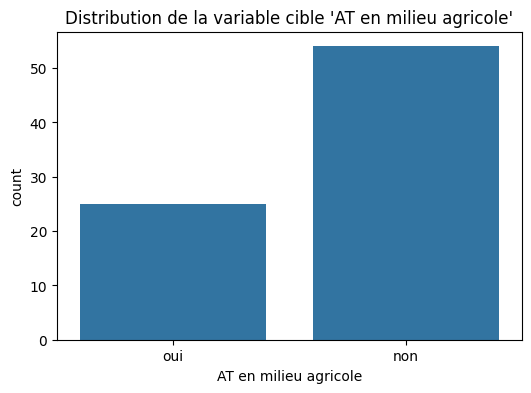

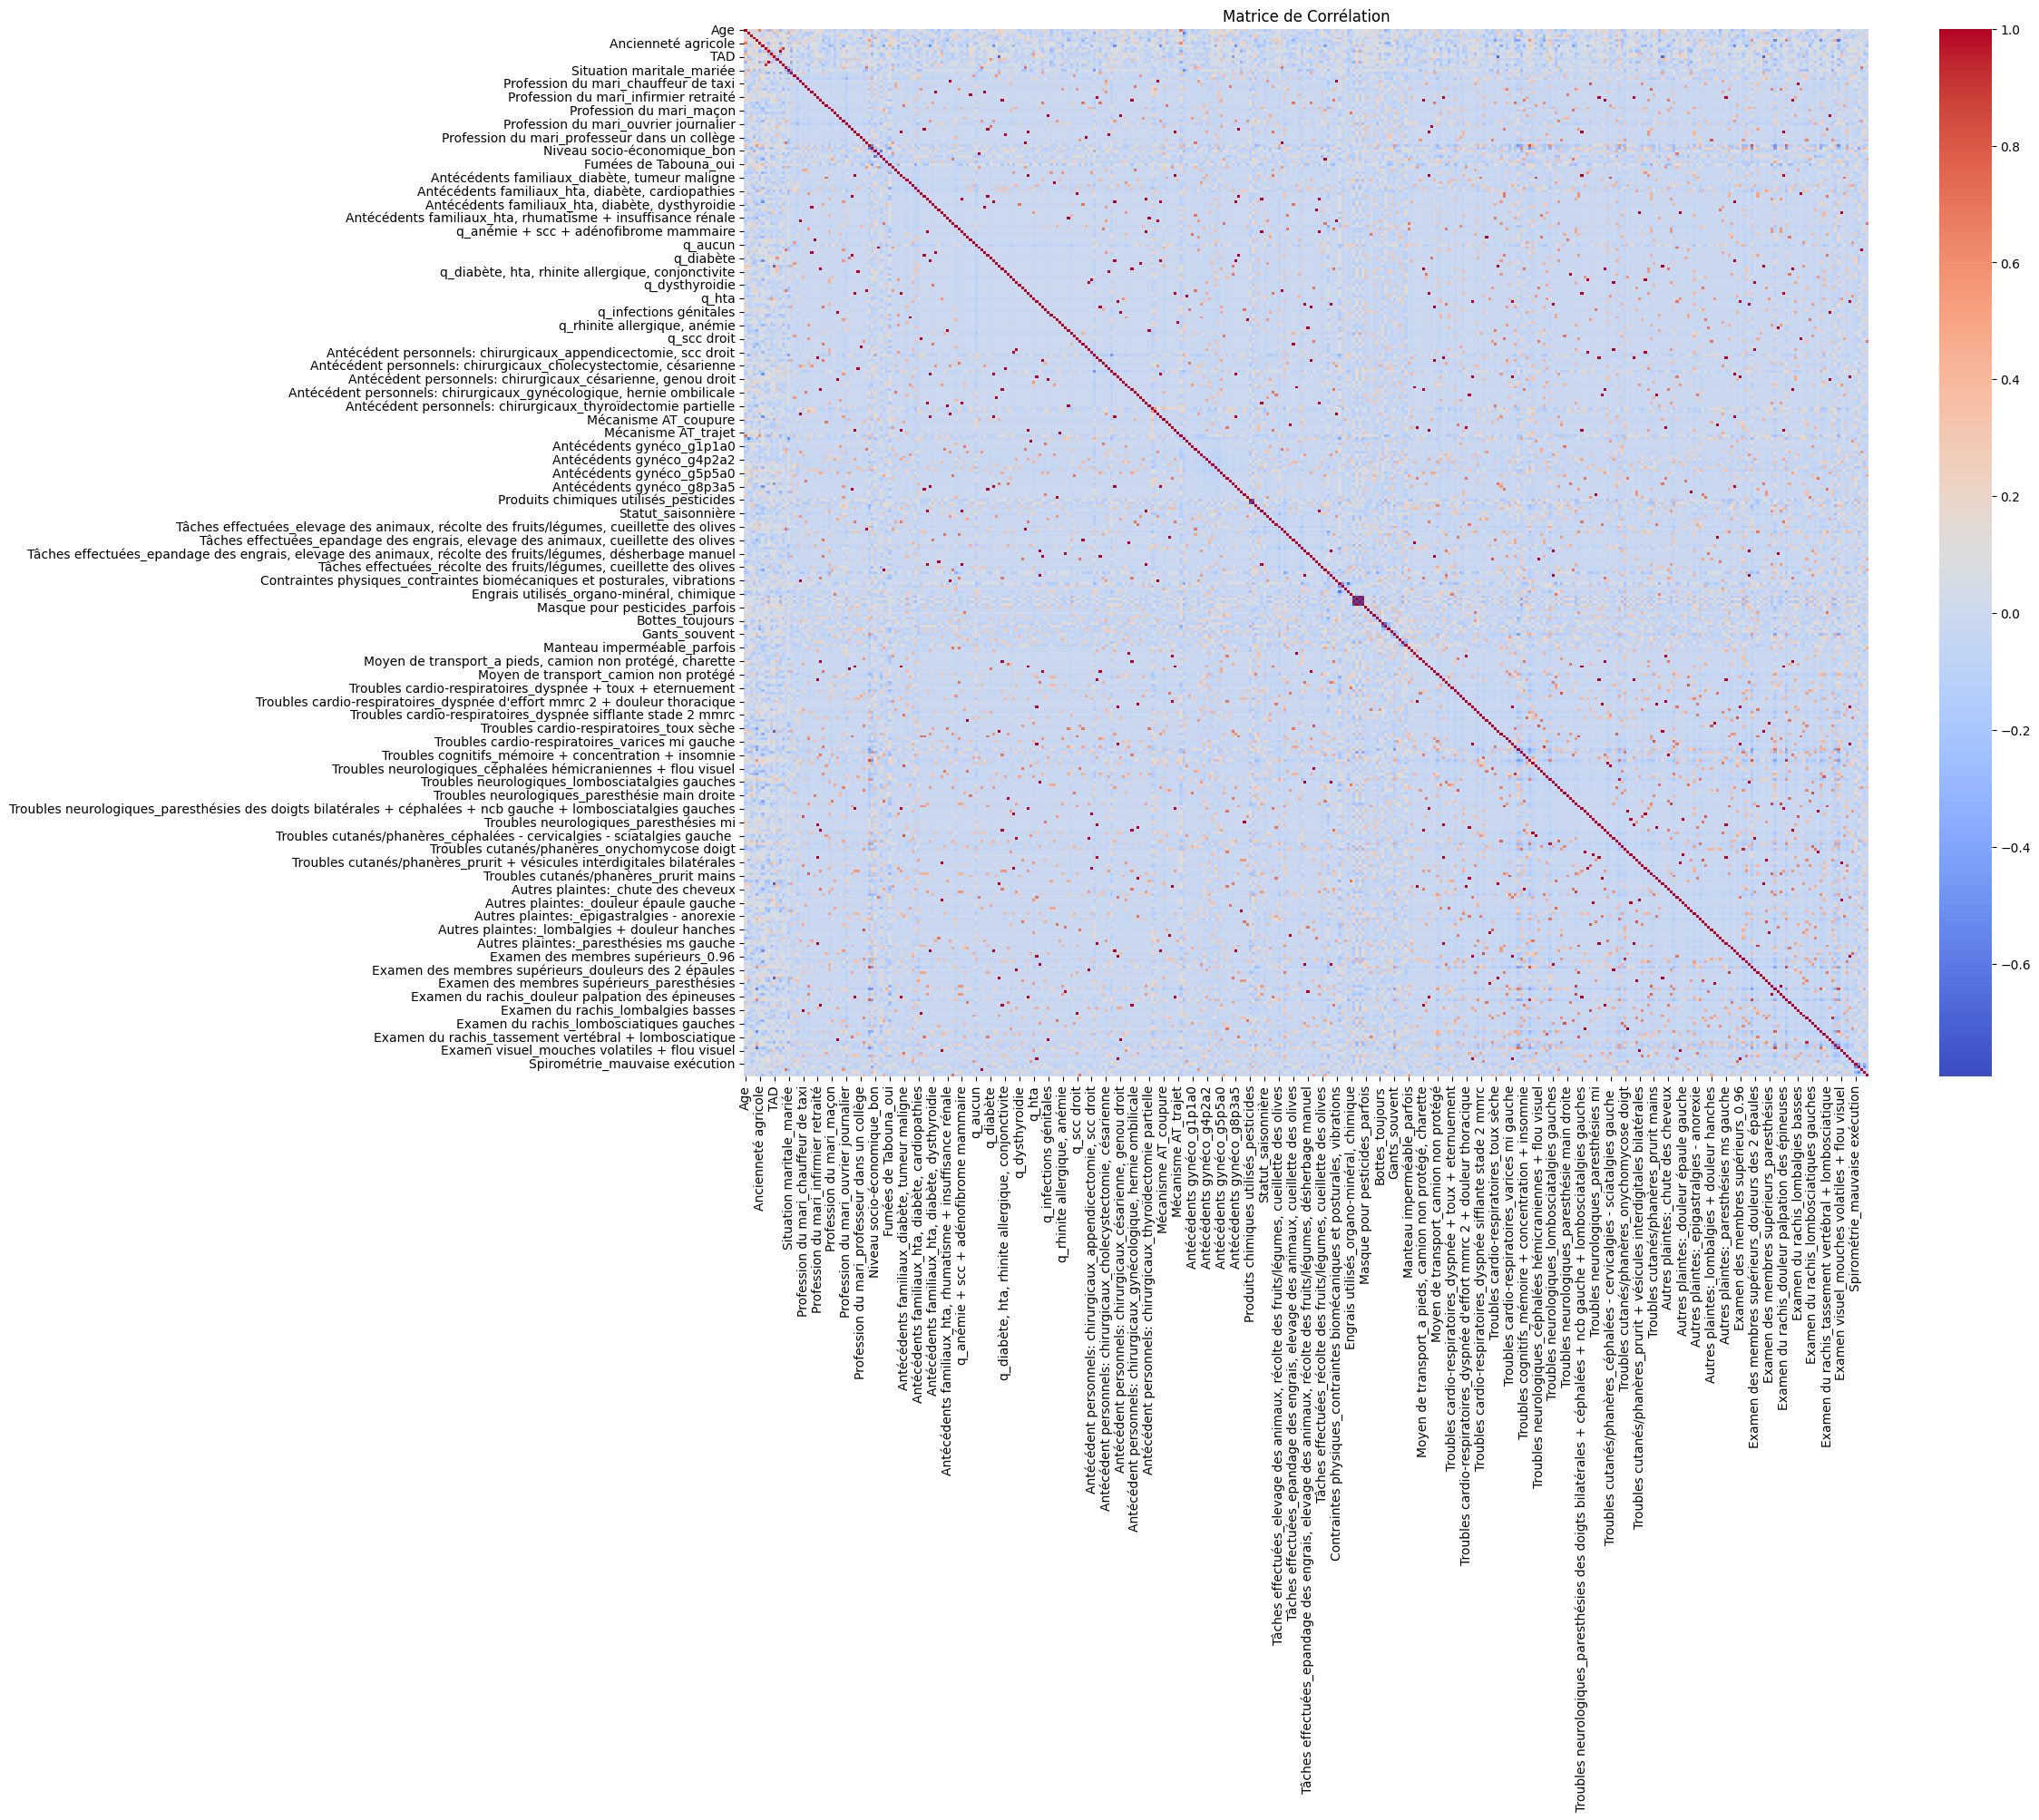

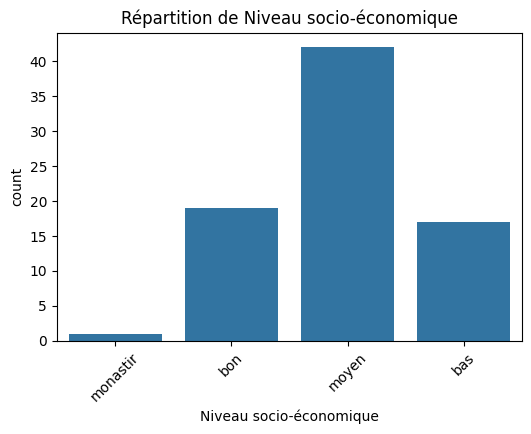

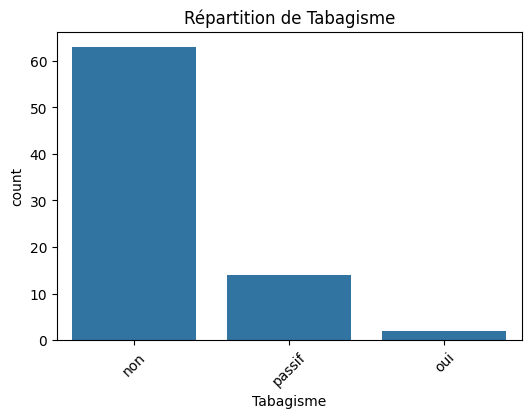

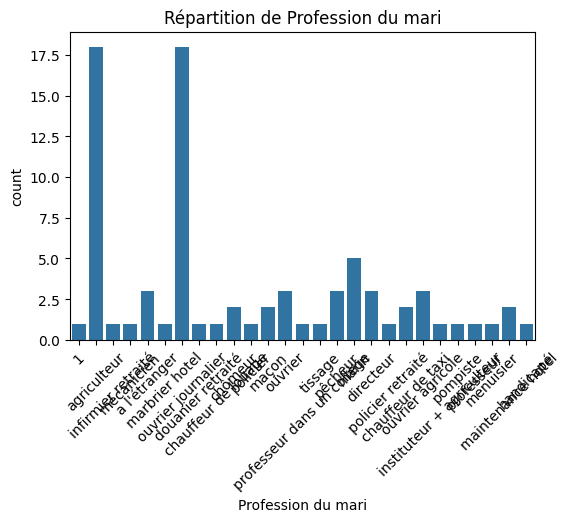


Dimensions des features apr√®s encodage : (79, 389)

Variables s√©lectionn√©es : ['Profession du mari_ch√¥meur', 'Profession du mari_marin', 'Domicile_monastir', 'Ant√©c√©dents familiaux_hta, diab√®te', 'q_rhumatisme', 'M√©canisme AT_chute', 'M√©canisme AT_coupure', 'M√©canisme AT_morsure chien', 'Ant√©c√©dents gyn√©co_g4p3a1', 'Ant√©c√©dents gyn√©co_g5p3a2', 'Ant√©c√©dents gyn√©co_g6p5a1', 'Ant√©c√©dents gyn√©co_g7p7a0', 'Cat√©gorie professionnelle_ouvri√®re', 'Cat√©gorie professionnelle_ouvri√®re, agricultrice ind√©pendante', 'Statut_saisonni√®re', 'T√¢ches effectu√©es_elevage des animaux, cueillette des olives, d√©sherbage manuel', 'T√¢ches effectu√©es_elevage des animaux, r√©colte des fruits/l√©gumes, cueillette des olives, d√©sherbage manuel', 'T√¢ches effectu√©es_epandage des engrais, elevage des animaux, r√©colte des fruits/l√©gumes, cueillette des olives, d√©sherbage manuel', "Contraintes physiques_contraintes biom√©caniques et posturales, contraintes m√©caniques (risque d'at)

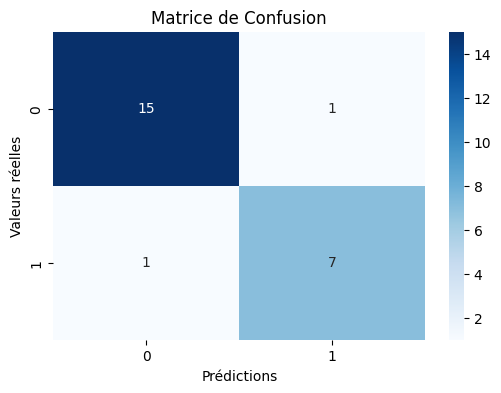

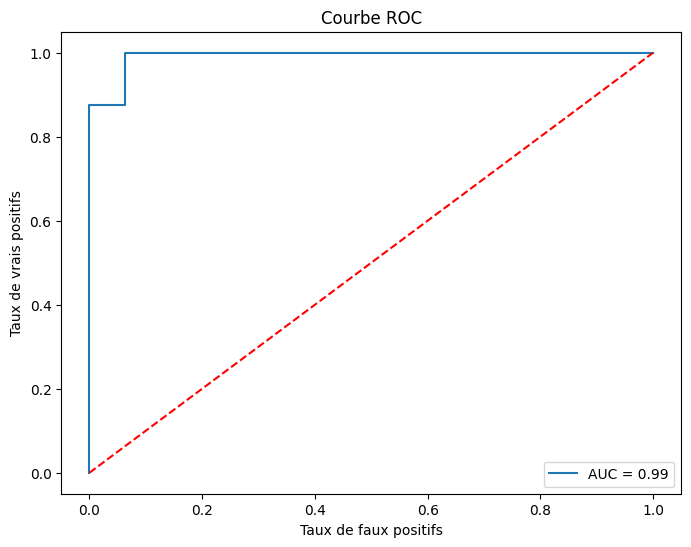

‚úÖ Score AUC ROC moyen (5-fold CV): 0.92


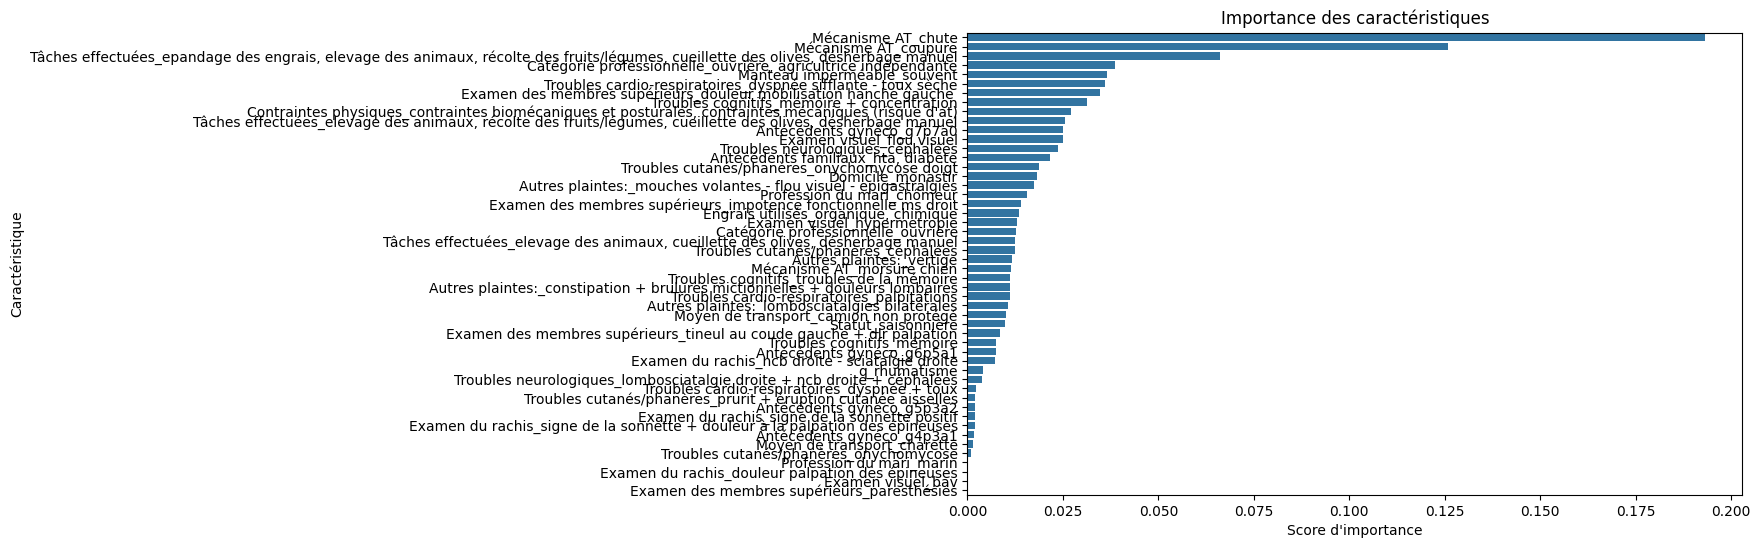

‚úÖ Mod√®le RandomForest sauvegard√© sous 'modele_rf.pkl'.


In [1]:
# =============================================================================
# SECTION 1 : Importation des biblioth√®ques n√©cessaires
# =============================================================================
import pandas as pd                # Manipulation des donn√©es
import numpy as np                 # Calculs num√©riques
import matplotlib.pyplot as plt    # Visualisations
import seaborn as sns              # Visualisations avanc√©es
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE  # Pour √©quilibrer les classes
import joblib                      # Pour sauvegarder le mod√®le
import math                        # Pour le calcul de la grille dans les plots

# Pour afficher les graphiques directement dans le notebook
%matplotlib inline

# =============================================================================
# SECTION 2 : Chargement du jeu de donn√©es
# =============================================================================
file_path = "/content/final_Dataset2.csv"  # Mettez √† jour le chemin si n√©cessaire
df = pd.read_csv(file_path)

print("Aper√ßu du dataset:")
print(df.head())
print("\nInformations g√©n√©rales sur le dataset:")
print(df.info())

# =============================================================================
# SECTION 3 : Pr√©paration et nettoyage des donn√©es
# =============================================================================
# 3.1 Suppression des colonnes inutiles
cols_to_drop = ['N¬∞', 'Nom', 'Pr√©nom', 'N¬∞ du t√©l√©phone']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True, errors='ignore')

# 3.2 Remplacement des valeurs manquantes :
# - Pour les colonnes num√©riques : remplacement par la m√©diane
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# - Pour les colonnes cat√©gorielles : remplacement par le mode (valeur la plus fr√©quente)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nNombre de valeurs manquantes apr√®s traitement:")
print(df.isnull().sum())

# =============================================================================
# SECTION 4 : Analyse exploratoire des donn√©es (EDA) et Visualisations
# =============================================================================

# 4.1 Statistiques descriptives
print("\nStatistiques descriptives:")
print(df.describe())

# 4.2 Histogrammes des variables num√©riques
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(math.ceil(len(num_cols)/3), 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

# 4.3 Boxplots pour d√©tecter les outliers (affichage de quelques variables)
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:6], 1):  # Affichage des 6 premi√®res variables num√©riques
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# 4.4 R√©partition de la variable cible 'AT en milieu agricole'
plt.figure(figsize=(6, 4))
sns.countplot(x='AT en milieu agricole', data=df)
plt.title("Distribution de la variable cible 'AT en milieu agricole'")
plt.show()

# 4.5 Matrice de corr√©lation (apr√®s encodage pour inclure les variables cat√©gorielles)
df_encoded_full = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(20, 15))
sns.heatmap(df_encoded_full.corr(), cmap='coolwarm', annot=False)
plt.title("Matrice de Corr√©lation")
plt.show()

# 4.6 Visualisations de variables cat√©gorielles importantes (si elles existent)
for col in ['Niveau socio-√©conomique', 'Tabagisme', 'Profession du mari']:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df)
        plt.title(f"R√©partition de {col}")
        plt.xticks(rotation=45)
        plt.show()

# =============================================================================
# SECTION 5 : Pr√©paration pour la mod√©lisation pr√©dictive
# =============================================================================
# D√©finir la variable cible (target)
target_col = 'AT en milieu agricole'
if target_col not in df.columns:
    raise ValueError(f"La colonne cible '{target_col}' n'existe pas dans le dataset.")

y = df[target_col]
X = df.drop(columns=[target_col])

# Encodage des variables cat√©gorielles pour les features
X_encoded = pd.get_dummies(X, drop_first=True)
print("\nDimensions des features apr√®s encodage :", X_encoded.shape)

# =============================================================================
# SECTION 6 : S√©lection des variables (SelectKBest)
# =============================================================================
# On s√©lectionne les 50 variables les plus pertinentes pour √©viter la mal√©diction de la dimension
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_encoded, y)
selected_feature_names = X_encoded.columns[selector.get_support()]
print("\nVariables s√©lectionn√©es :", list(selected_feature_names))

# =============================================================================
# SECTION 7 : D√©coupage en ensembles d'entra√Ænement et de test
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)
print("\nTaille de l'ensemble d'entra√Ænement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)

# =============================================================================
# SECTION 8 : √âquilibrage des classes avec SMOTE (pour corriger les d√©s√©quilibres)
# =============================================================================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("\nApr√®s SMOTE, forme de l'ensemble d'entra√Ænement :", X_train_bal.shape)

# =============================================================================
# SECTION 9 : Construction et entra√Ænement du mod√®le pr√©dictif
# =============================================================================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

# =============================================================================
# SECTION 10 : √âvaluation du mod√®le
# =============================================================================
# Pr√©dictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n‚úÖ Rapport de classification :")
print(classification_report(y_test, y_pred))

# 10.1 Matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Pr√©dictions")
plt.ylabel("Valeurs r√©elles")
plt.show()

# 10.2 Courbe ROC et calcul de l'AUC
# Pour roc_curve, si la cible est sous forme de cha√Ænes ('oui'/'non'), utiliser pos_label='oui'
try:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='oui')
except Exception as e:
    print("Erreur avec pos_label='oui', utilisation de pos_label=1")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title("Courbe ROC")
plt.legend(loc='lower right')
plt.show()

# 10.3 Validation crois√©e (5-fold CV)
cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='roc_auc')
print("‚úÖ Score AUC ROC moyen (5-fold CV): {:.2f}".format(cv_scores.mean()))

# =============================================================================
# SECTION 11 : Visualisation de l'importance des caract√©ristiques
# =============================================================================
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Importance des caract√©ristiques")
plt.xlabel("Score d'importance")
plt.ylabel("Caract√©ristique")
plt.show()

# =============================================================================
# SECTION 12 : Sauvegarde du mod√®le
# =============================================================================
joblib.dump(model, 'modele_rf.pkl')


print("‚úÖ Mod√®le RandomForest sauvegard√© sous 'modele_rf.pkl'.")

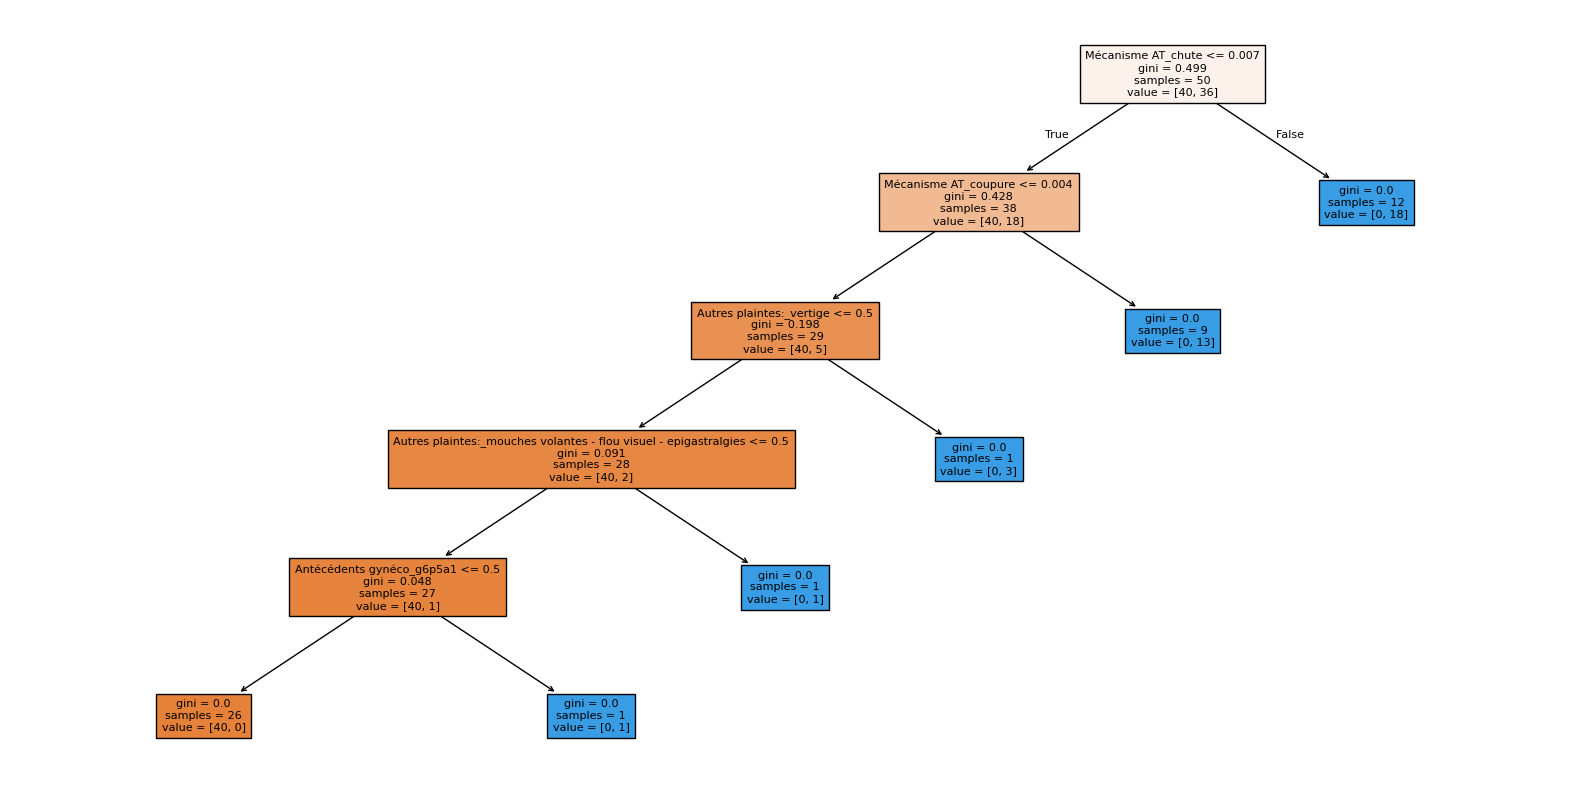

In [2]:
# extraction des r√®gles
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=list(selected_feature_names), filled=True, fontsize=8)
plt.show()


In [3]:
from sklearn.tree import export_text

# Parcourir chaque arbre de la for√™t al√©atoire et extraire ses r√®gles
for i, arbre in enumerate(model.estimators_[:3]):  # On affiche seulement les 3 premiers arbres pour √©viter un trop gros affichage
    print(f"\nüîπ R√®gles de l'arbre {i+1} :\n")
    rules = export_text(arbre, feature_names=list(selected_feature_names))
    print(rules)


üîπ R√®gles de l'arbre 1 :

|--- M√©canisme AT_chute <= 0.01
|   |--- M√©canisme AT_coupure <= 0.00
|   |   |--- Autres plaintes:_vertige <= 0.50
|   |   |   |--- Autres plaintes:_mouches volantes - flou visuel - epigastralgies <= 0.50
|   |   |   |   |--- Ant√©c√©dents gyn√©co_g6p5a1 <= 0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Ant√©c√©dents gyn√©co_g6p5a1 >  0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- Autres plaintes:_mouches volantes - flou visuel - epigastralgies >  0.50
|   |   |   |   |--- class: 1.0
|   |   |--- Autres plaintes:_vertige >  0.50
|   |   |   |--- class: 1.0
|   |--- M√©canisme AT_coupure >  0.00
|   |   |--- class: 1.0
|--- M√©canisme AT_chute >  0.01
|   |--- class: 1.0


üîπ R√®gles de l'arbre 2 :

|--- M√©canisme AT_chute <= 0.01
|   |--- Troubles cognitifs_troubles de la m√©moire <= 0.50
|   |   |--- Examen des membres sup√©rieurs_douleur mobilisation hanche gauche  <= 0.50
|   |   |   |--- M√©canisme AT_coupure <= 0.50
|  